# Introduction

I did a Time Series analysis on energy and temperature data in Spain from 01/01/2015 - 12/31/2018. Energy data pertained to hourly energy consumptiom, production, and price while temperature data pertained to hourly temperature and weather conditions.

[Data Source](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

## Objective
The goal of this analysis was to outperform the predictions made by the Transmission Service Operator (TSO) for hourly energy price and demand. I would like the predictors to be able to make forecasts 3 months into the future. Additionally, I want to explore different energy consumption profiles of customers in Spain to better understand power usage behavior.

By better modeling demand from our consumers as well as their behavior, we can more optimally set price points for hourly power costs as well as investigate ways to use alternative methods of energy prodcution. Though solar, wind, and hydro electric power are preferred alternatives in a growingly environemtntall conscous world, they are not as efficient as fossil and natrual gas ...yet. 

## Data Overview

### Preview Data

In [33]:
#Read in some libraries
import pandas as pd
import numpy as np
from IPython.display import Image

#Set notebook preferences - pandas
pd.set_option("display.max_columns", 101)

In [30]:
#Set path to clean aggregated data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\02_Cleaned_Data'

#Read in data
data = pd.read_csv(path + '/2020_0620_Weather_Energy.csv')

#Display data
display(data.head(10))


,date_time,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,price_actual,price_day_ahead,temp,total_load_actual,total_load_forecast
0,2015-01-01 00:00:00,17.0,6436.0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,65.41,50.10,30.814633,25385.0,26118.0
1,2015-01-01 01:00:00,16.0,5856.0,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,64.92,48.10,30.852860,24382.0,24934.0
2,2015-01-01 02:00:00,8.0,5454.0,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,64.48,47.33,30.108448,22734.0,23515.0
3,2015-01-01 03:00:00,2.0,5151.0,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,59.32,42.27,30.091044,21286.0,22642.0
4,2015-01-01 04:00:00,9.0,4861.0,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,56.04,38.41,30.192620,20264.0,21785.0
5,2015-01-01 05:00:00,4.0,4617.0,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,43.0,74.0,34.0,188.0,4618.0,53.63,35.72,29.973200,19905.0,21441.0
6,2015-01-01 06:00:00,3.0,4276.0,401.0,172.0,4040.0,3368.0,158.0,2108.0,961.0,848.0,7098.0,43.0,74.0,34.0,186.0,4397.0,51.73,35.13,30.035120,20010.0,21285.0
7,2015-01-01 07:00:00,12.0,3994.0,408.0,172.0,4030.0,3208.0,160.0,2031.0,983.0,1012.0,7099.0,43.0,72.0,35.0,189.0,3992.0,51.43,36.22,30.553880,20377.0,21545.0
8,2015-01-01 08:00:00,39.0,3602.0,413.0,177.0,4052.0,3335.0,161.0,2119.0,1001.0,1015.0,7098.0,43.0,73.0,54.0,198.0,3629.0,48.98,32.40,33.518480,20094.0,21443.0
9,2015-01-01 09:00:00,784.0,3212.0,419.0,177.0,4137.0,3437.0,163.0,2170.0,1041.0,1357.0,7097.0,43.0,74.0,743.0,198.0,3073.0,54.20,36.60,33.884960,20637.0,21560.0


### About the data

**Data Description**

In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
forecast_solar_day_ahead,35070.0,1438.825121,1677.661532,0.000000,69.000,576.0000,2635.000,5836.0000
forecast_wind_onshore_day_ahead,35070.0,5471.372512,3176.148983,237.000000,2979.000,4855.5000,7353.000,17430.0000
generation_biomass,35070.0,383.536128,85.348006,0.000000,333.000,367.0000,433.000,592.0000
generation_fossil_brown_coal/lignite,35070.0,448.060251,354.603125,0.000000,0.000,509.0000,757.000,999.0000
generation_fossil_gas,35070.0,5622.474309,2201.444741,0.000000,4126.000,4969.0000,6428.750,20034.0000
generation_fossil_hard_coal,35070.0,4256.296179,1961.968024,0.000000,2527.000,4474.0000,5839.000,8359.0000
generation_fossil_oil,35070.0,298.335358,52.518153,0.000000,263.000,300.0000,330.000,449.0000
generation_hydro_pumped_storage_consumption,35070.0,475.867237,792.594472,0.000000,0.000,68.0000,617.000,4523.0000
generation_hydro_run-of-river_and_poundage,35070.0,972.117536,400.740520,0.000000,637.000,906.0000,1250.000,2000.0000
generation_hydro_water_reservoir,35070.0,2605.122241,1835.141359,0.000000,1077.250,2165.0000,3757.000,9728.0000


**Data Information**

Features containing "ahead" or "forecast" refer to predictions made by the Transmission Service Operator (TSO) and part of the analyis will attempt to outperform these predictions.

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35070 entries, 0 to 35069
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date_time                                    35070 non-null  object 
 1   forecast_solar_day_ahead                     35070 non-null  float64
 2   forecast_wind_onshore_day_ahead              35070 non-null  float64
 3   generation_biomass                           35070 non-null  float64
 4   generation_fossil_brown_coal/lignite         35070 non-null  float64
 5   generation_fossil_gas                        35070 non-null  float64
 6   generation_fossil_hard_coal                  35070 non-null  float64
 7   generation_fossil_oil                        35070 non-null  float64
 8   generation_hydro_pumped_storage_consumption  35070 non-null  float64
 9   generation_hydro_run-of-river_and_poundage   35070 non-null  float64
 10

### Exploratory Data Analysis

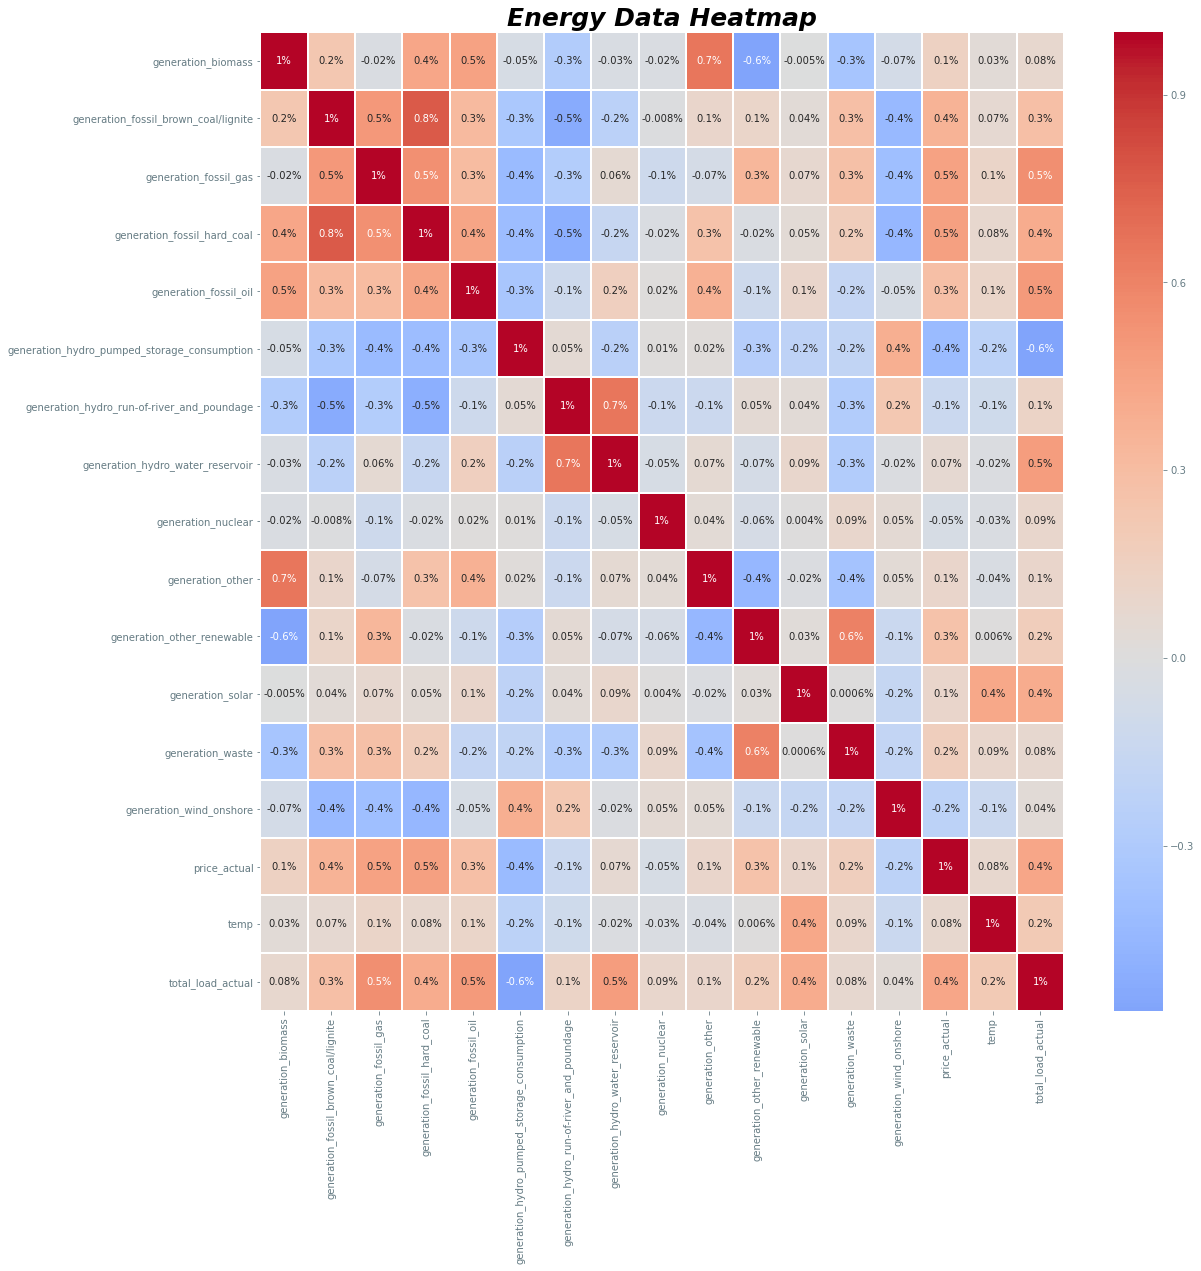

In [35]:
#Set path to EDA Visualizations
eda_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\01_Exploratory_Data_Analysis'
#Read in correlation matrix from EDA
Image(filename= eda_path + '/Correlation_Matrix.png', height=1300, width=1300)

# Methods

# Analysis Section - Explain what you analyzed. Include any charts here.

# Results - Describe the results of your analysis.

# Conclusion